In [19]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import sys
sys.path.append('../src')

from yf_dataset import *
from ta_features import *
from preprocessing import *

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [20]:
# Use GridSearchCV with timeseries split

In [21]:
ticker = 'ko'
label = 'KO'
start_date = '2020-01-01'
close_price_period = '1d'
target_pct_change_period = 30 # n = period

In [22]:
ko_df = get_stock_data(ticker, start_date, period=close_price_period)
format_col_names(ko_df)

add_pct_ch_and_future(ko_df, period = target_pct_change_period)
add_sma_rsi_sma_x_rsi(ko_df, [14, 20, 50, 100, 200])
add_ema(ko_df, [14, 20, 50, 100, 200])
add_wma(ko_df, [14, 20, 50, 100, 200])

# add_volume_1d_pct_change_sma(ko_df, 10)
add_volume_1d_pct_change_sma(ko_df, 30)

add_volume_1d_pct_change_sma(ko_df, 90)


ko_df.dropna(inplace=True)
#TODO: add volume and date features
#TODO: boosting algorithms




[*********************100%%**********************]  1 of 1 completed


c:\Users\user\Desktop\FMLProject\FML\notebooks\../src\ta_features.py:14: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  df[str(period) + 'd_close_future_pct'] = df[str(period) + 'd_future_close'].pct_change(period) #calc future % change


In [23]:
ko_df = add_datetime_features(ko_df,["month", "quarter"])

In [24]:
ko_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume', '30d_close_pct',
       '30d_future_close', '30d_close_future_pct', 'sma14', 'rsi14',
       'SMAxRSI_14', 'sma20', 'rsi20', 'SMAxRSI_20', 'sma50', 'rsi50',
       'SMAxRSI_50', 'sma100', 'rsi100', 'SMAxRSI_100', 'sma200', 'rsi200',
       'SMAxRSI_200', 'ema14', 'ema20', 'ema50', 'ema100', 'ema200', 'wma14',
       'wma20', 'wma50', 'wma100', 'wma200', 'Volume_1d_change',
       'Volume_30d_change_SMA', 'Volume_90d_change_SMA', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'quarter_1', 'quarter_2',
       'quarter_3'],
      dtype='object')

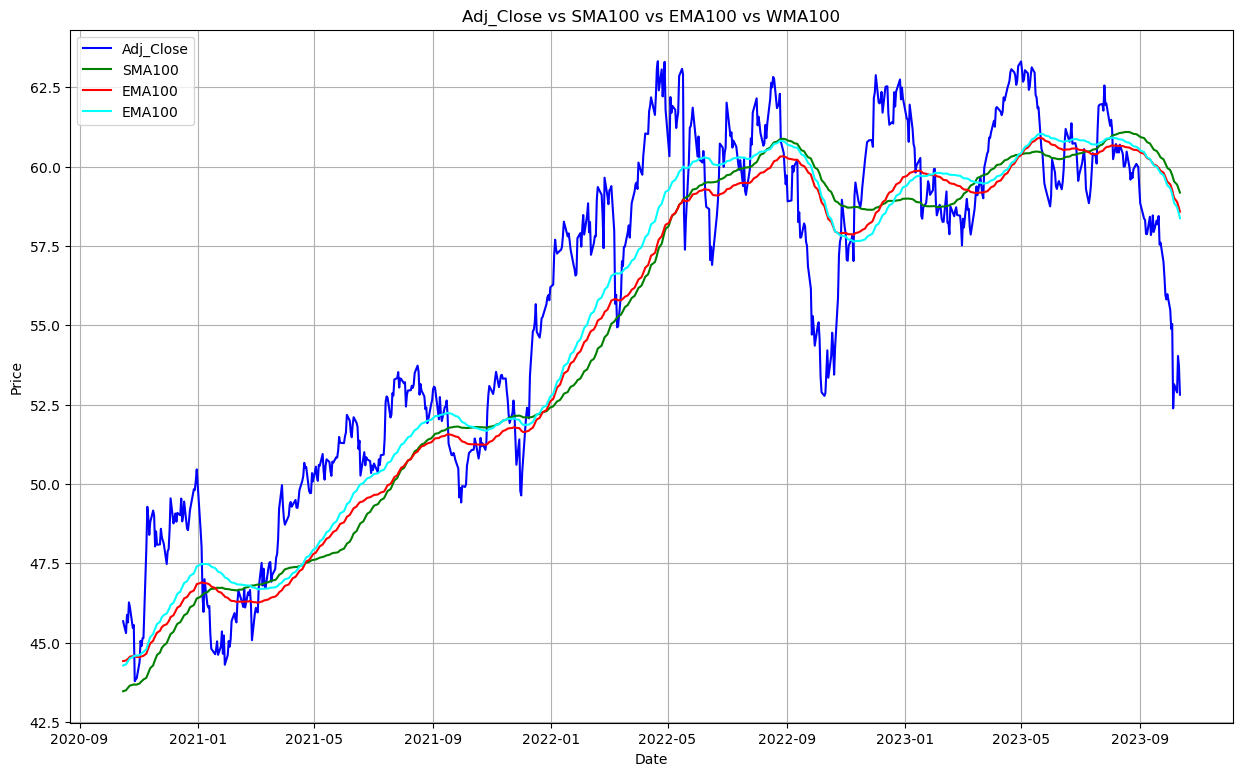

In [25]:
# Plotting
plt.figure(figsize=(15, 9))

# Plot Adj_Close
plt.plot(ko_df['Adj_Close'], label='Adj_Close', color='blue')

# Plot SMA200
plt.plot(ko_df['sma100'], label='SMA100', color='green')

# Plot EMA200
plt.plot(ko_df['ema100'], label='EMA100', color='red')

# Plot EMA200
plt.plot(ko_df['wma100'], label='EMA100', color='cyan')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Adj_Close vs SMA100 vs EMA100 vs WMA100')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
features, target = split_features_target(ko_df, f'{target_pct_change_period}d_close_future_pct', [f'{target_pct_change_period}d_future_close',f'{target_pct_change_period}d_close_pct'])

In [27]:
X = ko_df[features]
y = ko_df[target]
X.shape,y.shape
features

['Open',
 'High',
 'Low',
 'Close',
 'Adj_Close',
 'Volume',
 'sma14',
 'rsi14',
 'SMAxRSI_14',
 'sma20',
 'rsi20',
 'SMAxRSI_20',
 'sma50',
 'rsi50',
 'SMAxRSI_50',
 'sma100',
 'rsi100',
 'SMAxRSI_100',
 'sma200',
 'rsi200',
 'SMAxRSI_200',
 'ema14',
 'ema20',
 'ema50',
 'ema100',
 'ema200',
 'wma14',
 'wma20',
 'wma50',
 'wma100',
 'wma200',
 'Volume_1d_change',
 'Volume_30d_change_SMA',
 'Volume_90d_change_SMA',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'quarter_1',
 'quarter_2',
 'quarter_3']

In [28]:
# Create a time series split
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
scaler = StandardScaler()

# Identify columns to exclude from scaling
exclude_prefixes = ['month_', 'quarter_']
features_not_to_scale = [col for col in features if any(col.startswith(prefix) for prefix in exclude_prefixes)]

# Identify columns to scale
features_to_scale = [col for col in features if col not in features_not_to_scale]
# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), features_to_scale),
        ('passthrough', 'passthrough', features_not_to_scale)  # This passes through the specified features
    ],
    remainder='drop'  # Drop any columns not explicitly specified
)

# Define the pipeline with a RandomForestRegressor and a StandardScaler
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestRegressor(random_state=42))
])

# Define hyperparameter grid for grid search
param_grid = {
    'rf__n_estimators': [5, 10, 15, 20],
    'rf__max_depth': [5, 10, 20, 25, 30],
    'rf__min_samples_split': [2, 5, 10, 15, 20],
    'rf__min_samples_leaf': [1, 2, 4]
}

# Perform grid search with cross-validation using R-squared as the scoring metric
grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='r2', n_jobs=-1)
grid_search.fit(X, y)

# Print the best parameters and corresponding R-squared
print("Best Parameters: ", grid_search.best_params_)
print("Best R-squared: ", grid_search.best_score_)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

Best Parameters:  {'rf__max_depth': 10, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 20, 'rf__n_estimators': 10}
Best R-squared:  -0.8641313160646054


c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be

In [29]:
# n_samples = X.shape[0]                             # this is how test_size (s)
# s = n_samples//(n_splits + 1)                      # is evaluated internally              

# X_train, X_test = X[ :-s], X[-s: ]    # s=2 for this split
# y_train, y_test = y[ :-s], y[-s: ]

# y_train.shape, y_test.shape

In [30]:
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

y_train.shape, y_test.shape

((627,), (125,))

In [31]:
y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("r2: ", r2)

#TODO:
# SMAPE: Interpretation: Similar to MAPE but symmetrically accounts for both underestimation and overestimation. It is less sensitive to outliers.
# https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error

#TODO: make mlflow experiment

r2:  0.9441066112905474


c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be

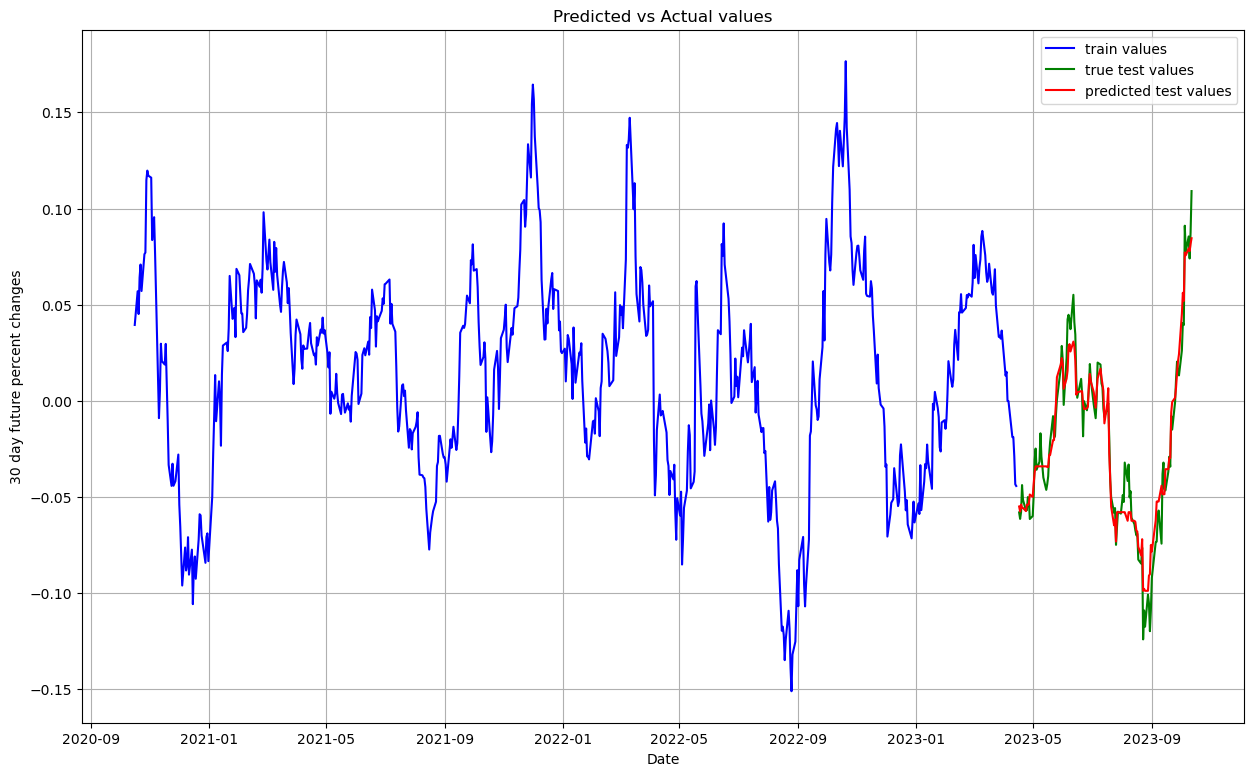

In [32]:
y_pred = pd.DataFrame(y_pred)
y_pred = y_pred.set_index(y_test.index)

# Plotting
plt.figure(figsize=(15, 9))

plt.plot(y_train, label='train values', color='blue')
plt.plot(y_test, label='true test values', color='green')
plt.plot(y_pred, label='predicted test values', color='red')

# Add labels and title
plt.xlabel('Date')
plt.ylabel(f'{target_pct_change_period} day future percent changes')
plt.title('Predicted vs Actual values')
plt.legend()
plt.grid(True)
plt.show()

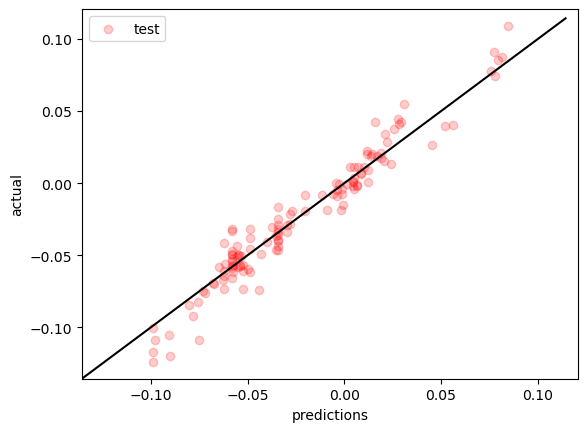

In [33]:
# Scatter the predictions vs the targets with 20% opacity
# plt.scatter(pred_train, y_train, alpha=0.2, color='b', label='train')
plt.scatter(y_pred, y_test, alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
perfect_line = np.arange(min(xmin, ymin), max(xmax, ymax), 0.01)
plt.plot(perfect_line, perfect_line, c='k')

# Set the same limits on x and y axes
plt.xlim([min(xmin, ymin), max(xmax, ymax)])
plt.ylim([min(xmin, ymin), max(xmax, ymax)])

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()

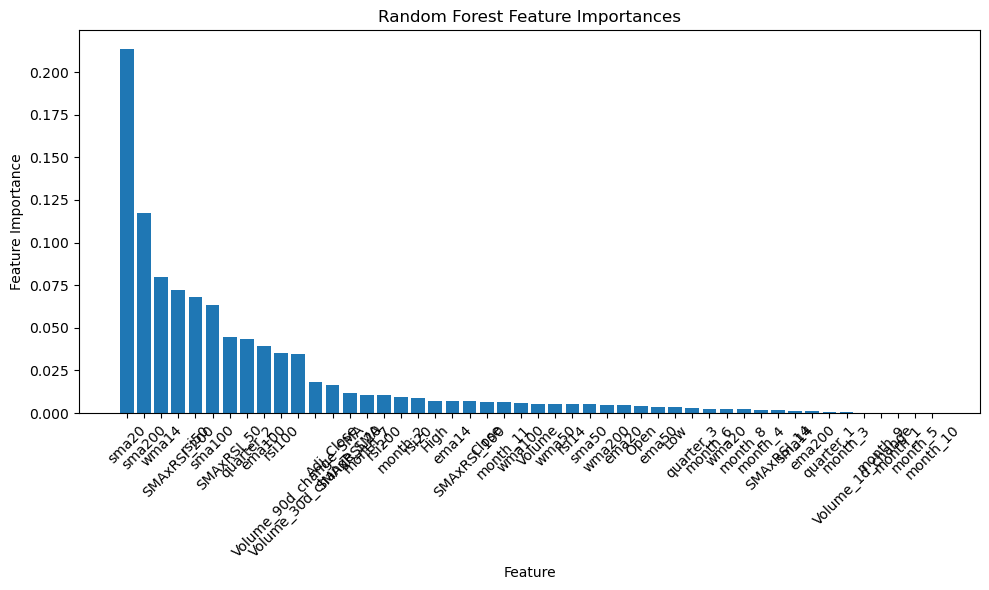

In [34]:
# Get feature importances from the trained Random Forest model
feature_importances = best_model.named_steps['rf'].feature_importances_

# Get the names of the features (assuming X is your feature matrix)
feature_names = X.columns

# Sort feature importances in descending order
sorted_idx = feature_importances.argsort()[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_idx], align="center")
plt.xticks(range(len(feature_importances)), feature_names[sorted_idx], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

In [35]:
with mlflow.start_run():

    # Log parameters
    mlflow.log_param("ticker", ticker)
    mlflow.log_param("scaling_method", "StandardScaler" if isinstance(scaler, StandardScaler) else "MinMaxScaler")
    mlflow.log_param("start_date", start_date)
    mlflow.log_param("target_variable", target)
    mlflow.log_param("features", features_to_scale)
    mlflow.log_param("categorical_features", features_not_to_scale)
    mlflow.log_param("hyperparameters", grid_search.best_params_)

    # Log metrics
    mlflow.log_metric("r-squared", r2)

     # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Model info", "Random Forest Regressor")

    # Infer the model signature
    signature = infer_signature(X_train, best_model.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=best_model,
        artifact_path="random_forest_regressor",
        signature=signature,
        input_example=X_train,
        registered_model_name="RFR_r2",
    )

c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\mlflow\models\signature.py:214: UserWarning: Hint: Inferred schema contains integer

# SMAPE metric

In [36]:



# Generate more features
# Scale the data
# Do dimensionality reduction with different techniques
# Perform grid search with time-series split

# extract feature importances after fitting the model
# sort feature importances feature importances

#Other models: gradient boosting and adaboost
# KNN regressor
# Neural Network
# - custom loss function - apply penalty to incorrect prediction direction